In [23]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import glob
import torch
from torch import nn
import torch.nn.functional as F
import  torch.optim as optim
from    matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
plt.rc('font',family='Times New Roman', size=16)

In [2]:
device

device(type='cuda')

In [3]:
def convert_2d(df_dup):
    data_frame = pd.DataFrame()
    for i in range(0, df_dup.shape[0]-59):
        is_anomaly = False
        mylist = []
        for j in range(i, i+60):
            mylist.append(df_dup['value'].iat[j])
            if df_dup['is_anomaly'].iat[j] == 1:
                is_anomaly = True
        if is_anomaly:
            mylist.append(1)
        else:
            mylist.append(0)
        np_Array = np.array(mylist)
        mylist = np_Array.T
        data_frame = data_frame.append(pd.Series(mylist), ignore_index=True)
    return data_frame

In [4]:
def get_data():
    dataset_conc=[]
    path=r'Dataset'
    all_files=glob.glob(path+"/*.csv")
    for filename in all_files:
        df=pd.read_csv(filename,index_col=None,header=0)
        #将数据中value为0的替换成NaN
        df=df.replace(0,np.nan)
        #处理value那层数据，将0去除掉
        df=df.dropna(axis=0, how='any',subset=['value'])
        df.value = preprocessing.normalize([df.value]).T
        dataset_conc.append(convert_2d(df))
    frame=pd.concat(dataset_conc,axis=0,ignore_index=True)
    y = frame.iloc[:, 60]
    X = frame.iloc[:, 0:60]
    X_train = X[:int(X.shape[0] * 0.7)]
    X_test = X[int(X.shape[0] * 0.7):]
    y_train = y[:int(X.shape[0] * 0.7)]
    y_test = y[int(X.shape[0] * 0.7):]


    X_train = X_train.to_numpy()
    nrows, ncols = X_train.shape
    X_train = X_train.reshape(nrows, ncols, 1)

    X_test = X_test.to_numpy()
    nrows, ncols = X_test.shape
    X_test = X_test.reshape(nrows, ncols, 1)

    y_test = y_test.to_numpy()
    # print("X_train:",X_train.shape)
    #[62107,60,1]
    # print("y_train:",y_train.shape)
    #[62107,]
    return X_train,y_train,X_test,y_test

In [5]:
X_train,y_train,X_test,y_test=get_data()

In [6]:
# 定义实现因果卷积的类
from torch.nn.utils import weight_norm
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# 定义了一个残差模块
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # n_inputs:输入通道数
        # n_outputs:输出通道数
        # stride：步长
        # padding:填充长度
        # dilation：扩张率
        # 定义第一个空洞卷积层
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 根据第一个卷积层的输出与padding大小实现因果卷积
        self.chomp1 = Chomp1d(padding)
        # 添加激活函数与dropout正则化方法完成第一个卷积
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # 堆叠同样结构的第二个卷积层
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # 将卷积模块的所有组建通过Sequential方法依次堆叠在一起
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 如果输出纬度和输入维度不一致，则必须对输出进行1X1卷积
        # 如果通道数不一样，那么需要对输入x做一个逐元素的一维卷积以使得它的纬度与前面两个卷积相等。
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        # 不同激活函数的尝试
        # self.sigmod = nn.Softmax()
        # self.tanh = nn.Tanh()
        # self.softPlus = nn.Softplus()
        # self.leaky = nn.LeakyReLU()
        self.init_weights()

    # 初始化为从均值为0，标准差为0.01的正态分布中采样的随机值
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    # 结合卷积与输入的恒等映射（或输入的逐元素卷积），并投入ReLU 激活函数完成残差模块
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


# 时间卷积网络
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=5, dropout=0.5):
        super(TemporalConvNet, self).__init__()
        # num_input:输入特征数，默认为1
        # num_levels:网络层数，每一层是一个残差块
        # num_channels:储存了所有层级的输出通道数
        layers = []
        # num_channels为各层卷积运算的输出通道数或卷积核数量
        num_levels = len(num_channels)
        # 空洞卷积的扩张系数若随着网络层级的增加而成指数级增加，则可以增大感受野并不丢弃任何输入序列的元素
        # dilation_size根据层级数成指数增加，并从num_channels中抽取每一个残差模块的输入通道数与输出通道数
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        # 将所有残差模块堆叠起来组成一个深度卷积网络
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x=self.network(x)
        #print('tcn_shape:',x.shape)
        return x

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
        )
        self.lstm=nn.LSTM(input_size=960, hidden_size=128, num_layers=1,batch_first=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            nn.Flatten(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )

    def forward(self,x):
        out=self.conv(x)
        out=out.reshape(-1,1,15*64)
        #[512,1,960]
        out, _ = self.lstm(out)
        #[512,1,128]
        out=self.fc(out)
        #[512,2]
        return out

In [8]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv=nn.Sequential(
            #[512,1,60]
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2,stride=2),
            #[512,32,30]
            nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),
            #[512,64,15]
        )
        self.lstm=nn.GRU(input_size=960, hidden_size=128, num_layers=1,batch_first=True)
        self.fc=nn.Sequential(
            nn.ReLU(),
            nn.Flatten(),
            #[512,128]
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32,2),
            #[512,2]
            nn.Softmax(dim=1)
        )

    def forward(self,x):
        out=self.conv(x)
        out=out.reshape(-1,1,15*64)
        #[512,1,960]
        out, _ = self.lstm(out)
        #[512,1,128]
        out=self.fc(out)
        #[512,2]
        return out

In [9]:
loss_list=[]
epoch_list=[]
acc_list=[]
ans_acc_list=[]
train_acc_list=[]

loss_list2=[]
epoch_list2=[]
acc_list2=[]
ans_acc_list2=[]
train_acc_list2=[]

In [10]:
import torch.utils.data as Data
from numpy import *
def train(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    # print(len(loader))
    #122
    net = Net()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()

    for epoch in range(521):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%30==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list.append(acc)
        ans_acc_list.append(acc)
        train_acc_list.append(train_acc)
        loss_list.append(loss.item())
        epoch_list.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list),4))
            acc_list.clear()
    torch.save(net.state_dict(),'model/net_lstm_params.pth')
    plt.plot(epoch_list,loss_list,color='red',label='training Loss')
    plt.plot(epoch_list,ans_acc_list,color='green',label='test Acc')
    plt.plot(epoch_list,train_acc_list,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [11]:
import torch.utils.data as Data
from numpy import *
def train2(input,y_train,X_test,y_test,new_input,new_y_train):
    torch_dataset=Data.TensorDataset(input,y_train)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        shuffle=True,  # 要不要打乱数据 (打乱比较好)
        num_workers=0,  # 多进程（multiprocess）来读数据
    )
    # print(len(loader))
    #122
    net = Net2()
    net=net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    net.train()

    for epoch in range(521):
        # 在一轮中迭代获取每个batch（把全部的数据分成小块一块块的训练）
        net.train()
        for step, (batch_x, batch_y) in enumerate(loader):
            input=batch_x.to(device)
            label=batch_y.to(device)
            # print("input:",input.shape)
            #[512,1,60]
            # print("label:",label.shape)
            #[512,2]
            y_pred=net(input)
            loss = F.binary_cross_entropy(y_pred,label)
            optimizer.zero_grad()
            loss.backward()
#             for p in net.parameters():
#               # print(p.grad.norm())                 # 查看参数p的梯度
#               torch.nn.utils.clip_grad_norm_(p, 10)  # 将梯度裁剪到小于10
            optimizer.step()
        flag=False
        if epoch%30==0:
          flag=True
        acc=test(net,X_test,y_test,flag)
        train_acc=test(net,new_input,new_y_train,flag)
        print('epoch', epoch, ':', loss.item(),'train_acc',train_acc,'test_acc：',acc)
        acc_list2.append(acc)
        ans_acc_list2.append(acc)
        train_acc_list2.append(train_acc)
        loss_list2.append(loss.item())
        epoch_list2.append(epoch)
        if epoch%100==0:
            print("acc平均值：",round(mean(acc_list2),4))
            acc_list2.clear()
    torch.save(net.state_dict(),'model/net_gru_params.pth')
    plt.plot(epoch_list2,loss_list2,color='red',label='training Loss')
    plt.plot(epoch_list2,ans_acc_list2,color='green',label='test Acc')
    plt.plot(epoch_list2,train_acc_list2,color='blue',label='training Acc')
    plt.legend()
    plt.show()

    return net

In [12]:
def test(model,x_test,y_test,flag):
    model.eval()
    torch_dataset=Data.TensorDataset(x_test,y_test)
    loader = Data.DataLoader(
        dataset=torch_dataset,  # 数据，封装进Data.TensorDataset()类的数据
        batch_size=512,  # 每块的大小
        num_workers=0,  # 多进程（multiprocess）来读数据
    )

    acc = 0.0
    count = 0
    ans_labels=[]
    ans_pre=[]
    for index, data in enumerate(loader):
        inputs, labels = data  # 5,3,400,600  5,10
        count += len(labels)
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)
        _, predict = torch.max(outputs, 1)
        acc += (labels == predict).sum().item()
        ans_labels+=labels.cpu().numpy().tolist()
        ans_pre+=predict.cpu().numpy().tolist()
    #evaluate performance
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    if flag==True:
      Confusion_Matrix = confusion_matrix(ans_labels, ans_pre)
      Accuracy = accuracy_score(ans_labels, ans_pre)
      precision = precision_score(ans_labels, ans_pre, average='binary')
      recall = recall_score(ans_labels, ans_pre, average='binary')
      F1_Score = f1_score(ans_labels, ans_pre, average='binary')
      print("Confusion_Matrix")
      print(Confusion_Matrix)
      print("Accuracy ", Accuracy)
      print("Precision ", precision)
      print("recall ", recall)
      print("f1_score ", F1_Score)
    return round(acc/count,4)

In [13]:
new_y_train=y_train
new_y_train=torch.tensor(new_y_train)
new_x_train=X_train
new_input=torch.tensor(new_x_train).permute(0,2,1).to(torch.float32)
y_train=F.one_hot(torch.tensor(y_train).to(torch.int64),2)
y_train=y_train.to(torch.float32)
#[batch_size,seq_len,embedding_size]=>[batch_size,embeding_size,seq_len]
input=torch.tensor(X_train).permute(0,2,1).to(torch.float32)
X_test = torch.tensor(X_test).permute(0, 2, 1).to(torch.float32)
y_test=torch.tensor(y_test)

D:\code_software\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[23986     0]
 [ 2632     0]]
Accuracy  0.9011195431662784
Precision  0.0
recall  0.0
f1_score  0.0


D:\code_software\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[56266     0]
 [ 5841     0]]
Accuracy  0.9059526301383097
Precision  0.0
recall  0.0
f1_score  0.0
epoch 0 : 0.23074272274971008 train_acc 0.906 test_acc： 0.9011
acc平均值： 0.9011
epoch 1 : 0.4056190550327301 train_acc 0.906 test_acc： 0.9011
epoch 2 : 0.36214205622673035 train_acc 0.906 test_acc： 0.9011
epoch 3 : 0.23071618378162384 train_acc 0.906 test_acc： 0.9011
epoch 4 : 0.27307695150375366 train_acc 0.906 test_acc： 0.9011
epoch 5 : 0.33397379517555237 train_acc 0.906 test_acc： 0.9011
epoch 6 : 0.3630331754684448 train_acc 0.906 test_acc： 0.9011
epoch 7 : 0.3276924192905426 train_acc 0.906 test_acc： 0.9011
epoch 8 : 0.24553030729293823 train_acc 0.924 test_acc： 0.911
epoch 9 : 0.11676117777824402 train_acc 0.9295 test_acc： 0.9184
epoch 10 : 0.14504264295101166 train_acc 0.9308 test_acc： 0.9198
epoch 11 : 0.33104828000068665 train_acc 0.9318 test_acc： 0.9222
epoch 12 : 0.2723020315170288 train_acc 0.9319 test_acc： 0.9259
epoch 13 : 0.22014668583869934 train_acc 0.932

epoch 110 : 0.06742484867572784 train_acc 0.9759 test_acc： 0.9178
epoch 111 : 0.11055996268987656 train_acc 0.9782 test_acc： 0.918
epoch 112 : 0.09108197689056396 train_acc 0.975 test_acc： 0.9187
epoch 113 : 0.10612510144710541 train_acc 0.9774 test_acc： 0.9297
epoch 114 : 0.0554104782640934 train_acc 0.9766 test_acc： 0.9292
epoch 115 : 0.037145357578992844 train_acc 0.9783 test_acc： 0.9252
epoch 116 : 0.05302663519978523 train_acc 0.9814 test_acc： 0.9244
epoch 117 : 0.07928134500980377 train_acc 0.9789 test_acc： 0.8962
epoch 118 : 0.06405340880155563 train_acc 0.9825 test_acc： 0.9196
epoch 119 : 0.03414033725857735 train_acc 0.9807 test_acc： 0.9158
Confusion_Matrix
[[22777  1209]
 [ 1082  1550]]
Accuracy  0.9139304230220152
Precision  0.5617977528089888
recall  0.5889057750759878
f1_score  0.5750324615099239
Confusion_Matrix
[[56077   189]
 [  886  4955]]
Accuracy  0.9826911620268247
Precision  0.963258164852255
recall  0.8483136449238144
f1_score  0.9021392808375056
epoch 120 : 0.058

epoch 214 : 0.26227879524230957 train_acc 0.95 test_acc： 0.9201
epoch 215 : 0.10679294168949127 train_acc 0.9514 test_acc： 0.9181
epoch 216 : 0.11748816817998886 train_acc 0.9509 test_acc： 0.9209
epoch 217 : 0.13830703496932983 train_acc 0.9522 test_acc： 0.9187
epoch 218 : 0.2063768208026886 train_acc 0.9545 test_acc： 0.917
epoch 219 : 0.16449889540672302 train_acc 0.9551 test_acc： 0.916
epoch 220 : 0.14355118572711945 train_acc 0.9563 test_acc： 0.9192
epoch 221 : 0.13052725791931152 train_acc 0.9554 test_acc： 0.9208
epoch 222 : 0.24815720319747925 train_acc 0.9576 test_acc： 0.9213
epoch 223 : 0.17218206822872162 train_acc 0.9592 test_acc： 0.9199
epoch 224 : 0.08286531269550323 train_acc 0.9587 test_acc： 0.9228
epoch 225 : 0.17176185548305511 train_acc 0.9612 test_acc： 0.9225
epoch 226 : 0.07355988025665283 train_acc 0.962 test_acc： 0.9202
epoch 227 : 0.19401629269123077 train_acc 0.9608 test_acc： 0.9105
epoch 228 : 0.07420847564935684 train_acc 0.9633 test_acc： 0.917
epoch 229 : 0.096

epoch 324 : 0.05569134280085564 train_acc 0.9828 test_acc： 0.926
epoch 325 : 0.07037657499313354 train_acc 0.9835 test_acc： 0.9152
epoch 326 : 0.048277631402015686 train_acc 0.9842 test_acc： 0.9163
epoch 327 : 0.03469603881239891 train_acc 0.9838 test_acc： 0.9249
epoch 328 : 0.024692608043551445 train_acc 0.9831 test_acc： 0.9214
epoch 329 : 0.02742723561823368 train_acc 0.9837 test_acc： 0.9128
Confusion_Matrix
[[22623  1363]
 [  957  1675]]
Accuracy  0.9128409347058382
Precision  0.5513495720868993
recall  0.6363981762917933
f1_score  0.5908289241622574
Confusion_Matrix
[[56144   122]
 [  838  5003]]
Accuracy  0.9845428051588387
Precision  0.9761951219512195
recall  0.8565314158534497
f1_score  0.9124566842969176
epoch 330 : 0.04712953045964241 train_acc 0.9845 test_acc： 0.9128
epoch 331 : 0.050361208617687225 train_acc 0.9859 test_acc： 0.913
epoch 332 : 0.02368313819169998 train_acc 0.9827 test_acc： 0.9267
epoch 333 : 0.04366011917591095 train_acc 0.9867 test_acc： 0.9187
epoch 334 : 0

epoch 429 : 0.04176015406847 train_acc 0.9803 test_acc： 0.9331
epoch 430 : 0.10332641750574112 train_acc 0.9816 test_acc： 0.9279
epoch 431 : 0.04690082371234894 train_acc 0.9794 test_acc： 0.9419
epoch 432 : 0.06144607067108154 train_acc 0.9819 test_acc： 0.9269
epoch 433 : 0.05412342771887779 train_acc 0.9825 test_acc： 0.936
epoch 434 : 0.04571099579334259 train_acc 0.982 test_acc： 0.9394
epoch 435 : 0.03491891548037529 train_acc 0.9856 test_acc： 0.9291
epoch 436 : 0.026604969054460526 train_acc 0.9849 test_acc： 0.9334
epoch 437 : 0.026979008689522743 train_acc 0.9852 test_acc： 0.9399
epoch 438 : 0.02009776048362255 train_acc 0.9848 test_acc： 0.939
epoch 439 : 0.050356440246105194 train_acc 0.9861 test_acc： 0.935
epoch 440 : 0.06914584338665009 train_acc 0.9868 test_acc： 0.9342
epoch 441 : 0.04084794968366623 train_acc 0.9865 test_acc： 0.9381
epoch 442 : 0.060555800795555115 train_acc 0.9836 test_acc： 0.9414
epoch 443 : 0.06058535352349281 train_acc 0.985 test_acc： 0.9413
epoch 444 : 0.

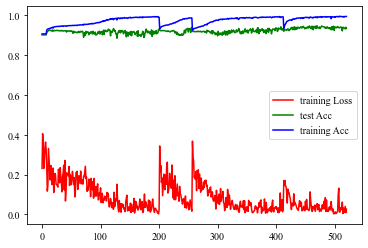

In [14]:
model=train(input,y_train,X_test,y_test,new_input,new_y_train)

D:\code_software\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[23986     0]
 [ 2632     0]]
Accuracy  0.9011195431662784
Precision  0.0
recall  0.0
f1_score  0.0


D:\code_software\anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion_Matrix
[[56266     0]
 [ 5841     0]]
Accuracy  0.9059526301383097
Precision  0.0
recall  0.0
f1_score  0.0
epoch 0 : 0.22394698858261108 train_acc 0.906 test_acc： 0.9011
acc平均值： 0.9011
epoch 1 : 0.3619741201400757 train_acc 0.9164 test_acc： 0.9024
epoch 2 : 0.2749495804309845 train_acc 0.921 test_acc： 0.9058
epoch 3 : 0.2593920826911926 train_acc 0.9275 test_acc： 0.9156
epoch 4 : 0.19695159792900085 train_acc 0.9297 test_acc： 0.922
epoch 5 : 0.3117437958717346 train_acc 0.9292 test_acc： 0.918
epoch 6 : 0.25431644916534424 train_acc 0.9301 test_acc： 0.9186
epoch 7 : 0.26873379945755005 train_acc 0.9315 test_acc： 0.9199
epoch 8 : 0.20931006968021393 train_acc 0.9316 test_acc： 0.9223
epoch 9 : 0.22526614367961884 train_acc 0.9328 test_acc： 0.9241
epoch 10 : 0.2091841697692871 train_acc 0.9346 test_acc： 0.9219
epoch 11 : 0.21761730313301086 train_acc 0.9312 test_acc： 0.9232
epoch 12 : 0.25926369428634644 train_acc 0.9362 test_acc： 0.9233
epoch 13 : 0.09657960385084152 train_acc 

epoch 110 : 0.006747070234268904 train_acc 0.9875 test_acc： 0.9459
epoch 111 : 0.03777211531996727 train_acc 0.9888 test_acc： 0.9469
epoch 112 : 0.020014846697449684 train_acc 0.9883 test_acc： 0.9391
epoch 113 : 0.015397502109408379 train_acc 0.9914 test_acc： 0.9432
epoch 114 : 0.034051328897476196 train_acc 0.993 test_acc： 0.9411
epoch 115 : 0.3141724467277527 train_acc 0.8922 test_acc： 0.8995
epoch 116 : 0.43712562322616577 train_acc 0.9269 test_acc： 0.9167
epoch 117 : 0.28441935777664185 train_acc 0.9294 test_acc： 0.9186
epoch 118 : 0.20096780359745026 train_acc 0.9312 test_acc： 0.9192
epoch 119 : 0.2446121871471405 train_acc 0.9326 test_acc： 0.9206
Confusion_Matrix
[[23723   263]
 [ 1852   780]]
Accuracy  0.9205424900443309
Precision  0.74784276126558
recall  0.29635258358662614
f1_score  0.4244897959183674
Confusion_Matrix
[[55932   334]
 [ 3768  2073]]
Accuracy  0.9339526945432882
Precision  0.8612380556709597
recall  0.3549049820236261
f1_score  0.5026673132880698
epoch 120 : 0.

epoch 215 : 0.10141723603010178 train_acc 0.9828 test_acc： 0.9421
epoch 216 : 0.0639556497335434 train_acc 0.9843 test_acc： 0.933
epoch 217 : 0.09273660182952881 train_acc 0.9748 test_acc： 0.8964
epoch 218 : 0.025049317628145218 train_acc 0.981 test_acc： 0.9429
epoch 219 : 0.03712040185928345 train_acc 0.9816 test_acc： 0.9404
epoch 220 : 0.03599196672439575 train_acc 0.983 test_acc： 0.9411
epoch 221 : 0.0323675274848938 train_acc 0.9839 test_acc： 0.9408
epoch 222 : 0.038627561181783676 train_acc 0.9866 test_acc： 0.928
epoch 223 : 0.00812970194965601 train_acc 0.9823 test_acc： 0.9341
epoch 224 : 0.06590518355369568 train_acc 0.9861 test_acc： 0.9273
epoch 225 : 0.0530441515147686 train_acc 0.9859 test_acc： 0.9331
epoch 226 : 0.06754598021507263 train_acc 0.9831 test_acc： 0.8925
epoch 227 : 0.020683521404862404 train_acc 0.9854 test_acc： 0.9169
epoch 228 : 0.07233038544654846 train_acc 0.9868 test_acc： 0.9331
epoch 229 : 0.01401415653526783 train_acc 0.9829 test_acc： 0.8999
epoch 230 : 0.

epoch 324 : 0.04580923542380333 train_acc 0.9914 test_acc： 0.9393
epoch 325 : 0.012032056227326393 train_acc 0.9916 test_acc： 0.9268
epoch 326 : 0.002746855840086937 train_acc 0.993 test_acc： 0.9326
epoch 327 : 0.015019542537629604 train_acc 0.9923 test_acc： 0.934
epoch 328 : 0.013669927604496479 train_acc 0.9928 test_acc： 0.9192
epoch 329 : 0.003982214722782373 train_acc 0.9919 test_acc： 0.9411
Confusion_Matrix
[[23154   832]
 [  771  1861]]
Accuracy  0.9397775941092493
Precision  0.6910508726327516
recall  0.7070668693009119
f1_score  0.6989671361502348
Confusion_Matrix
[[56225    41]
 [  373  5468]]
Accuracy  0.9933340847247493
Precision  0.9925576329642404
recall  0.9361410717342921
f1_score  0.9635242290748899
epoch 330 : 0.008801356889307499 train_acc 0.9933 test_acc： 0.9398
epoch 331 : 0.05314760282635689 train_acc 0.9911 test_acc： 0.9247
epoch 332 : 0.015339953824877739 train_acc 0.9919 test_acc： 0.9209
epoch 333 : 0.002247957745566964 train_acc 0.9926 test_acc： 0.9384
epoch 33

epoch 428 : 0.19963598251342773 train_acc 0.9461 test_acc： 0.9222
epoch 429 : 0.19211244583129883 train_acc 0.9477 test_acc： 0.9268
epoch 430 : 0.19008217751979828 train_acc 0.9552 test_acc： 0.9195
epoch 431 : 0.13128900527954102 train_acc 0.955 test_acc： 0.9161
epoch 432 : 0.12921835482120514 train_acc 0.9592 test_acc： 0.9283
epoch 433 : 0.12964780628681183 train_acc 0.9612 test_acc： 0.9287
epoch 434 : 0.1424250453710556 train_acc 0.9638 test_acc： 0.9205
epoch 435 : 0.08993099629878998 train_acc 0.9642 test_acc： 0.9285
epoch 436 : 0.16238969564437866 train_acc 0.9636 test_acc： 0.9342
epoch 437 : 0.11844053864479065 train_acc 0.9663 test_acc： 0.9317
epoch 438 : 0.07767032086849213 train_acc 0.9689 test_acc： 0.9313
epoch 439 : 0.02508668228983879 train_acc 0.9671 test_acc： 0.9373
epoch 440 : 0.06072358787059784 train_acc 0.9709 test_acc： 0.9328
epoch 441 : 0.09536856412887573 train_acc 0.974 test_acc： 0.9307
epoch 442 : 0.0643354281783104 train_acc 0.9754 test_acc： 0.9325
epoch 443 : 0.

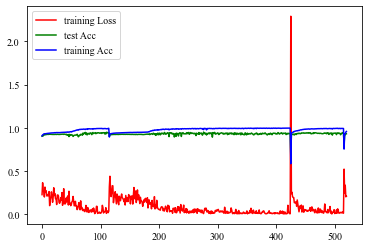

In [15]:
model2=train2(input,y_train,X_test,y_test,new_input,new_y_train)

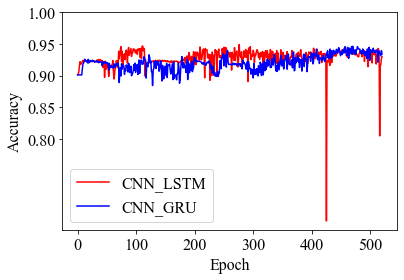

In [24]:
# plt.plot(epoch_list,loss_list,color='red',label='training Loss')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(epoch_list,ans_acc_list2,color='red',label='CNN_LSTM')
plt.plot(epoch_list,ans_acc_list,color='blue',label='CNN_GRU')
plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()

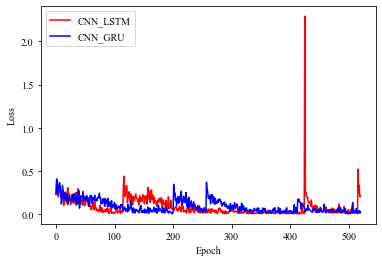

In [17]:
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list,loss_list2,color='red',label='CNN_LSTM')
plt.plot(epoch_list,loss_list,color='blue',label='CNN_GRU')
# plt.yticks([0.8,0.85,0.90,0.95,1])
plt.legend()
plt.show()

In [18]:
print("123")

123
